<a href="https://colab.research.google.com/github/VladKarad/AI_education/blob/main/Text_processing_Model_Sequence_to_Sequence_Translator_HW_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Lite.
В данной задаче требуется создать 2 модели для перевода.
1. С английского на русский.
2. С русского на английский.

По итогу требуется подать выход первой модели во вторую модель и сравнить начальный текст и дважды переведенный.
Добиться максимальной точности.

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

In [ ]:
# Загрузим обучающие тексты
!wget  http://www.manythings.org/anki/rus-eng.zip

--2022-01-10 17:50:48--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14683939 (14M) [application/zip]
Saving to: ‘rus-eng.zip.1’

rus-eng.zip.1       100%[===================>]  14.00M  51.5MB/s    in 0.3s    

2022-01-10 17:50:49 (51.5 MB/s) - ‘rus-eng.zip.1’ saved [14683939/14683939]



In [ ]:
# Распакуем архив
!unzip -o rus-eng.zip 

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
conversations = []                                # Заготовим список для пар фраз

with open("rus.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().split('\n')                  # Читаем весь файл, режем на строки

# Цикл по строкам
for i,line in enumerate(lines):
    
    if i>50000:                                         # Нам нужно только 50000 первых строк
      break                                             # Заканчиваем цикл
    try:
        input_text, target_text,_ = line.split("\t")    # Берем очередную строку, режем по символу табуляции
        conversations.append([input_text, target_text]) # Заполняем список пар фраз
    except:
        continue                                        # если не получается - идем за следущей строкой

In [ ]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания

        Args: строка или список строк

        Returns: строка или список строк
    '''

    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз
questions1 = [] # Переменная для списка входных фраз
answers1 = []   # Переменная для списка ответных фраз

# Цикл по всем парам фраз 
for con in conversations:                 
  
    if len(con) > 1 :                       # Если ответная фраза содержит более одно двух предложений
        questions.append(my_replacer(con[0])) # То первую в списке фразу отправляем в список входных фраз
        answers1.append(my_replacer(con[0])) # То первую в списке фразу отправляем в список входных фраз
        replies = my_replacer(con[1:])        # А ответную составляем из последующих строк
        ans = ' '.join(replies)               # Здесь соберем ответ
        answers.append(ans)                   # Добавим в список ответов
        questions1.append(ans)                   # Добавим в список ответов
    else:
        continue                              # Иначе идем на новой парой фраз

# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]
answers1 = ['<START> ' + s + ' <END>' for s in answers1]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[111])) # Пример входной фразы
print('Ответ : {}'.format(answers[111]))    # Пример ответной фразы
print('Вопрос1 : {}'.format(questions1[111])) # Пример входной фразы
print('Ответ1 : {}'.format(answers1[111]))    # Пример ответной фразы

Вопрос : Go now.
Ответ : <START> Иди сейчас. <END>
Вопрос1 : Иди сейчас.
Ответ1 : <START> Go now. <END>


In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))             

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('том', 6), ('не', 7), ('это', 8), ('you', 9), ('is', 10), ('a', 11), ("i'm", 12), ('ты', 13), ('мы', 14), ('мне', 15), ('the', 16), ('it', 17), ('was', 18), ('we', 19), ('to', 20), ('вы', 21), ('у', 22), ('do', 23), ('it.', 24), ('в', 25), ('он', 26), ('меня', 27), ('tom.', 28), ('my', 29), ("it's", 30), ('you.', 31), ("don't", 32), ('are', 33), ('can', 34), ('me.', 35), ('did', 36), ("you're", 37), ('your', 38), ('he', 39), ('они', 40), ('на', 41), ('был', 42), ('this', 43), ('have', 44), ('что', 45), ('not', 46), ('go', 47), ("i'll", 48), ('that', 49), ('be', 50)]
Размер словаря : 26464


In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions1 + answers1)         

# Список с cодержимым словаря
vocabularyItems1 = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize1 = len(vocabularyItems1)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems1[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize1))             

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('том', 6), ('не', 7), ('это', 8), ('you', 9), ('is', 10), ('a', 11), ("i'm", 12), ('ты', 13), ('мы', 14), ('мне', 15), ('the', 16), ('it', 17), ('was', 18), ('we', 19), ('to', 20), ('вы', 21), ('у', 22), ('do', 23), ('it.', 24), ('в', 25), ('он', 26), ('меня', 27), ('tom.', 28), ('my', 29), ("it's", 30), ('you.', 31), ("don't", 32), ('are', 33), ('can', 34), ('me.', 35), ('did', 36), ("you're", 37), ('your', 38), ('he', 39), ('они', 40), ('на', 41), ('был', 42), ('this', 43), ('что', 44), ('have', 45), ('not', 46), ('go', 47), ("i'll", 48), ('that', 49), ('be', 50)]
Размер словаря : 26464


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[100]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))        

Пример входной фразы                         : Freeze!
Пример кодированной входной фразу            : [7350    0    0    0    0    0]
Размеры закодированного массива входных фраз : (50001, 6)
Установленная длина входных фраз             : 6


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions1 = tokenizer.texts_to_sequences(questions1)

# Уточняем длину самой длинной фразы
maxLenQuestions1 = max([ len(x) for x in tokenizedQuestions1])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions1 = pad_sequences(tokenizedQuestions1, maxlen=maxLenQuestions1, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput1 = np.array(paddedQuestions1)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions1[100]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput1[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput1.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions1))        

Пример входной фразы                         : Ни с места!
Пример кодированной входной фразу            : [ 1043    59 10262     0     0     0     0     0     0     0]
Размеры закодированного массива входных фраз : (50001, 10)
Установленная длина входных фраз             : 10


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))                       

Пример оригинального ответа на вход: <START> Ни с места! <END>
Пример кодированного ответа на вход : [    1  1043    59 10262     2     0     0     0     0     0     0     0]
Размеры кодированного массива ответов на вход : (50001, 12)
Установленная длина ответов на вход : 12


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers1 = tokenizer.texts_to_sequences(answers1) 

# Уточняем длину самого длинного ответа
maxLenAnswers1 = max([len(x) for x in tokenizedAnswers1])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers1 = pad_sequences(tokenizedAnswers1, maxlen=maxLenAnswers1, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput1 = np.array(paddedAnswers1)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers1[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput1[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput1.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers1))     

Пример оригинального ответа на вход: <START> Freeze! <END>
Пример кодированного ответа на вход : [   1 7350    2    0    0    0    0    0]
Размеры кодированного массива ответов на вход : (50001, 8)
Установленная длина ответов на вход : 8


In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
    tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)                                             

In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers1 = tokenizer.texts_to_sequences(answers1) 

for i in range(len(tokenizedAnswers1)) :                  # Для разбитых на последовательности ответов
    tokenizedAnswers1[i] = tokenizedAnswers1[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers1 = pad_sequences(tokenizedAnswers1, maxlen=maxLenAnswers1 , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput1 = np.array(paddedAnswers1)                                             

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers))                    

Пример кодированного ответа на вход : [    1  1043    59 10262     2     0     0     0     0     0     0     0]
Пример кодированного ответа на выход : [ 1043    59 10262     2     0     0     0     0     0     0     0     0]
Размеры кодированного массива ответов на выход : (50001, 12)
Установленная длина вопросов на выход : 12


In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput1[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput1[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput1.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers1))                    

Пример кодированного ответа на вход : [   1 7350    2    0    0    0    0    0]
Пример кодированного ответа на выход : [7350    2    0    0    0    0    0    0]
Размеры кодированного массива ответов на выход : (50001, 8)
Установленная длина вопросов на выход : 8


In [ ]:
# Создадим энкодер 

encoderInputs = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)  # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding) # Добавим LSTM
encoderStates = [state_h, state_c]                                                 # Соберем выходы lstm  в список    

In [ ]:
# Создадим энкодер 1

encoderInputs1 = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding1 = Embedding(vocabularySize1, 200 , mask_zero=True)(encoderInputs1)  # Добавим эмбеддинг
encoderOutputs1, state_h1 , state_c1 = LSTM(200, return_state=True)(encoderEmbedding1) # Добавим LSTM
encoderStates1 = [state_h1, state_c1]                                                 # Соберем выходы lstm  в список    

In [ ]:
# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
# Создадим декодер 1

decoderInputs1 = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding1 = Embedding(vocabularySize1, 200, mask_zero=True) (decoderInputs1)    # Добавим эмбеддинг
decoderLSTM1 = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs1 , _ , _ = decoderLSTM1 (decoderEmbedding1, initial_state=encoderStates1) # Прогоним выход embedding через LSTM
decoderDense1 = Dense(vocabularySize1, activation='softmax')                           # Создадим dense слой
output1 = decoderDense1 (decoderOutputs1)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
# Собираем модель

model = Model([encoderInputs, decoderInputs], output)

In [ ]:
model1 = Model([encoderInputs1, decoderInputs1], output1)

In [ ]:
# Компилиуем модель

model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

In [ ]:
# Компилиуем модель

model1.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

In [ ]:
# Выведем на экран информацию о построенной модели нейросети

print(model.summary())  

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 200)    5292800     ['input_5[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, None, 200)    5292800     ['input_7[0][0]']                
                                                                                            

In [ ]:
# Выведем на экран информацию о построенной модели нейросети

print(model1.summary())  

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 200)    5292800     ['input_6[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, None, 200)    5292800     ['input_8[0][0]']                
                                                                                            

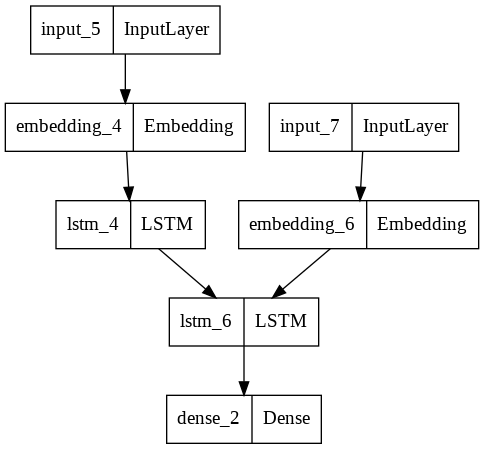

In [ ]:
# Построим график для визуализации слоев и связей между ними

plot_model(model, to_file='model.png')

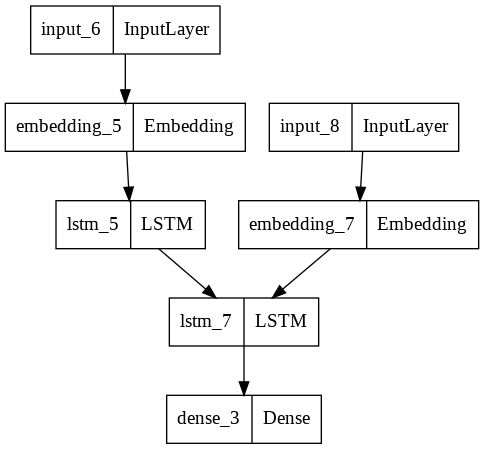

In [ ]:
# Построим график для визуализации слоев и связей между ними

plot_model(model1, to_file='model.png')

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=30) 

# Сохраним модель на диске
model.save( 'content/model_30epochs(rms).h5' )

Epoch 1/30
196/196 [==============================] - 30s 107ms/step - loss: 2.0072
Epoch 2/30
196/196 [==============================] - 21s 107ms/step - loss: 1.5492
Epoch 3/30
196/196 [==============================] - 21s 107ms/step - loss: 1.3856
Epoch 4/30
196/196 [==============================] - 21s 107ms/step - loss: 1.2771
Epoch 5/30
196/196 [==============================] - 21s 107ms/step - loss: 1.1900
Epoch 6/30
196/196 [==============================] - 21s 107ms/step - loss: 1.1147
Epoch 7/30
196/196 [==============================] - 21s 107ms/step - loss: 1.0489
Epoch 8/30
196/196 [==============================] - 21s 106ms/step - loss: 0.9898
Epoch 9/30
196/196 [==============================] - 21s 107ms/step - loss: 0.9396
Epoch 10/30
196/196 [==============================] - 21s 107ms/step - loss: 0.8927
Epoch 11/30
196/196 [==============================] - 21s 106ms/step - loss: 0.8503
Epoch 12/30
196/196 [==============================] - 21s 107ms/step - lo

In [ ]:
# Сохраним веса модели
model.save_weights('content/s2s_30epochs.h5')

In [ ]:
# Запустим обучение
model1.fit([encoderForInput1 , decoderForInput1], decoderForOutput1, batch_size=256, epochs=30) 

# Сохраним модель на диске
model1.save( 'content/model_30epochs(rms)1.h5' )

Epoch 1/30
196/196 [==============================] - 26s 86ms/step - loss: 2.9329
Epoch 2/30
196/196 [==============================] - 17s 85ms/step - loss: 2.1082
Epoch 3/30
196/196 [==============================] - 17s 85ms/step - loss: 1.8168
Epoch 4/30
196/196 [==============================] - 17s 85ms/step - loss: 1.6041
Epoch 5/30
196/196 [==============================] - 17s 85ms/step - loss: 1.4309
Epoch 6/30
196/196 [==============================] - 17s 85ms/step - loss: 1.2889
Epoch 7/30
196/196 [==============================] - 17s 85ms/step - loss: 1.1705
Epoch 8/30
196/196 [==============================] - 17s 85ms/step - loss: 1.0712
Epoch 9/30
196/196 [==============================] - 17s 85ms/step - loss: 0.9822
Epoch 10/30
196/196 [==============================] - 17s 85ms/step - loss: 0.9017
Epoch 11/30
196/196 [==============================] - 17s 85ms/step - loss: 0.8302
Epoch 12/30
196/196 [==============================] - 17s 85ms/step - loss: 0.7685
E

In [ ]:
# Сохраним веса модели
model.save_weights('content/s2s_30epochs1.h5')

# 1

In [ ]:
def makeInferenceModels():

    ''' Функция сборки сети для перевода фраз из уже обученных слов

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel = Model(encoderInputs, encoderStates) 

    # Создадим модель декодера
    decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
    decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

    # Соберем оба inputs вместе и запишем в decoderStatesInputs
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) 
    
    # LSTM даст нам новые состояния
    decoderStates = [state_h, state_c]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs = decoderDense(decoderOutputs) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel , decoderModel

In [ ]:
def makeInferenceModels1():

    ''' Функция сборки сети для перевода фраз из уже обученных слов

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel1 = Model(encoderInputs1, encoderStates1) 

    # Создадим модель декодера
    decoderStateInput_h1 = Input(shape=(200 ,)) # Добавим входной слой для state_h
    decoderStateInput_c1 = Input(shape=(200 ,)) # Добавим входной слой для state_c

    # Соберем оба inputs вместе и запишем в decoderStatesInputs
    decoderStatesInputs1 = [decoderStateInput_h1, decoderStateInput_c1] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs1, state_h1, state_c1 = decoderLSTM1(decoderEmbedding1, initial_state=decoderStatesInputs1) 
    
    # LSTM даст нам новые состояния
    decoderStates1 = [state_h1, state_c1]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs1 = decoderDense1(decoderOutputs1) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel1 = Model([decoderInputs1] + decoderStatesInputs1, [decoderOutputs1] + decoderStates1)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel1 , decoderModel1

In [ ]:
def strToTokens(sentence: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

In [ ]:
def strToTokens1(sentence1: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence1)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLenQuestions1 , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

In [ ]:
import numpy as np
emptyTargetSeq = np.zeros((1, 1))


emptyTargetSeq[0, 0] = 5

emptyTargetSeq

array([[5.]])

In [ ]:
encModel , decModel = makeInferenceModels() 

In [ ]:
encModel1 , decModel1 = makeInferenceModels1() 

In [ ]:
# Цикл по количеству входных фраз - их 6

for _ in range(6):

    # подготовка
    
    qua  = strToTokens(input('Исходное предложение на английском: '))
    if qua is None:                                      
        print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        continue                                             # Пойдем за следущей фразой

    emptyTargetSeq = np.zeros((1, 1))                    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
    stopCondition = False                                
    decodedTranslation = '' 
    statesValues = encModel.predict(qua)                              

    # пока не сработало стоп-условие
    while not stopCondition:                             

        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
        # Получим индекс предсказанного слова.
        sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():

        
        # Если индекс выбранного слова соответствует какому-то индексу из словаря
          if sampledWordIndex == index:              
            # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
            decodedTranslation += ' {}'.format(word) 
            # Выбранное слово фиксируем в переменную sampledWord
            sampledWord = word                       
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
          if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
            stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
          emptyTargetSeq = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
          emptyTargetSeq[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
          statesValues = [h, c]   

        # И продолжаем цикл с обновленными параметрами                
                                                
    # Выводим ответ сгенерированный декодером
    print("Перевод: ", decodedTranslation)


    # подготовка
    
    qua  = strToTokens1(decodedTranslation)
    if qua is None:                                      
        print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        continue                                             # Пойдем за следущей фразой

    emptyTargetSeq = np.zeros((1, 1))                    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
    stopCondition = False                                
    decodedTranslation = '' 
    statesValues = encModel1.predict(qua)                              

    # пока не сработало стоп-условие
    while not stopCondition:                             

        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = decModel1.predict([emptyTargetSeq] + statesValues)
        # Получим индекс предсказанного слова.
        sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():

        
        # Если индекс выбранного слова соответствует какому-то индексу из словаря
          if sampledWordIndex == index:              
            # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
            decodedTranslation += ' {}'.format(word) 
            # Выбранное слово фиксируем в переменную sampledWord
            sampledWord = word                       
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
          if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers1:
            stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
          emptyTargetSeq = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
          emptyTargetSeq[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
          statesValues = [h, c]   

        # И продолжаем цикл с обновленными параметрами                
                                                
    # Выводим ответ сгенерированный декодером
    print("Перевод: ", decodedTranslation)     

Исходное предложение на английском: what is your name?
Перевод:   как твоё имя? end
Перевод:   what's your name? end
